### Extracting data from the JSON files

In [137]:
DATA_SIZE = 1569264
SAMPLE_SIZE = 70000
TRAIN_SIZE = 60000

In [139]:
import numpy as np
import json 
import pandas

business_ratings = { }
for line in open("data/yelp_academic_dataset_business.json", "r"):
    json_data = json.loads(line)
    business_ratings[json_data["business_id"]] = json_data["stars"]
#selected_businesses = set(np.random.choice(business_ratings.keys(), size = 2000, replace = False))
    
review_list = []

selected = set(np.random.choice(np.arange(DATA_SIZE), size=SAMPLE_SIZE, replace=False))
for line_num, line in enumerate(open("data/yelp_academic_dataset_review.json", "r")):
    if line_num in selected:
        json_data = json.loads(line)
        review_list.append([json_data["review_id"], json_data["stars"], json_data["text"], json_data["business_id"]])
        
review_pd = pandas.DataFrame(review_list, columns = ["Review ID", "Stars", "Review Text", "Business ID"])

### Tokenizing the review text

In [140]:
import sys
import string
import unicodedata
from nltk.tokenize import RegexpTokenizer

tbl = dict.fromkeys(i for i in xrange(sys.maxunicode) if unicodedata.category(unichr(i)).startswith('P'))

def tokenize(text):
    return text.translate(tbl).lower().split()

review_pd["Tokenized Text"] = review_pd["Review Text"].apply(tokenize)

In [4]:
review_pd.head()

,Review ID,Stars,Review Text,Business ID,Tokenized Text
0,XsEghKHgnKLG1j1_oi1DeA,2,This Giant Eagle truly is giant! And believe ...,BG4N0V93wml9kaU6YYRxRA,"[this, giant, eagle, truly, is, giant, and, be..."
1,8D45qGrqu1kqNrHwbFBcog,2,I have to agree that this is one of the poor e...,BG4N0V93wml9kaU6YYRxRA,"[i, have, to, agree, that, this, is, one, of, ..."
2,lSIgshZ-whIhru0zuT4hPg,5,I am emotionally attached to this place.This p...,BG4N0V93wml9kaU6YYRxRA,"[i, am, emotionally, attached, to, this, place..."
3,_zEDqXNOYaf7rBKiAc2e_A,2,I cannot in my life understand why this Giant ...,BG4N0V93wml9kaU6YYRxRA,"[i, cannot, in, my, life, understand, why, thi..."
4,OCaFvItTD4LHox1Wig-3rg,2,This Giant Eagle seems more like a GetGo than ...,BG4N0V93wml9kaU6YYRxRA,"[this, giant, eagle, seems, more, like, a, get..."


In [93]:
review_pd.shape

(53475, 5)

In [12]:
%matplotlib inline
review_pd.groupby("Stars").count()

,Review ID,Review Text,Business ID,Tokenized Text
Stars,,,,
1,5179,5179,5179,5179
2,4656,4656,4656,4656
3,7065,7065,7065,7065
4,15609,15609,15609,15609
5,20966,20966,20966,20966


### Manipulating data into LabeledSentences

In [129]:
from gensim.models.doc2vec import LabeledSentence
import numpy as np

class LabeledSentences:
    
    def __init__(self, series):
        self.series = series
        
    def __iter__(self):
        indexes = list(np.arange(len(self.series)))
        np.random.shuffle(indexes)
        for (index, wordlist) in self.series.iloc[indexes].iteritems():
        #for (index, wordlist) in self.series.iteritems():
            yield LabeledSentence(words = wordlist, tags = ['VEC_%s' % index])
            
sentences = LabeledSentences(review_pd["Tokenized Text"].copy())

### Learn vector representations for each word via Word2Vec

In [130]:
import multiprocessing
import gensim
from gensim.models import Doc2Vec

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be slow otherwise"
cores = multiprocessing.cpu_count()

model = Doc2Vec(dm = 1, dm_concat = 0, min_count = 1, window = 10, size = 100, sample = 1e-4, negative = 5, 
                workers = cores, alpha = 0.025, min_alpha = 0.025)
model.build_vocab(sentences)

### Learn vector representations for each review text via Doc2Vec

In [131]:
for epoch in range(10):
    model.train(sentences)
    #model.alpha -= 0.002
    #model.min_alpha = model.alpha

### Concatenate Review Rating with Vector

In [111]:
np.random.choice(np.arange(20))

14

In [132]:
design_matrix, labels = [], []
test_matrix, t_labels = [], []

train_indices = set(np.random.choice(np.arange(len(model.docvecs)), replace=False, size=TRAIN_SIZE))
for index in xrange(len(model.docvecs)):
    key = ("VEC_%s") % (index)
    
    if index in train_indices:
        design_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
        labels.append(business_ratings[review_pd["Business ID"][index]])
    else:
        test_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
        t_labels.append(business_ratings[review_pd["Business ID"][index]])
    
design_matrix = np.array(design_matrix)
labels = np.array(labels)
#labels = (np.array(labels) > 3).astype(int)

test_matrix = np.array(test_matrix)
t_labels = np.array(t_labels)
#t_labels = (np.array(t_labels) > 3).astype(int)

(array([     0.,      0.,     67.,    330.,    717.,   1378.,   4191.,
          9235.,  15534.,   7000.,   1548.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5]),
 <a list of 11 Patch objects>)

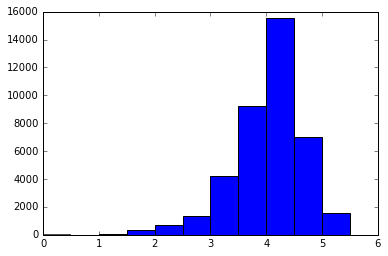

In [133]:
import matplotlib.pyplot as plt
plt.hist(labels,bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5])

In [134]:
labels_binary = (labels >= 4).astype(int)
t_labels_binary = (t_labels >= 4).astype(int)

In [135]:
t_labels_binary.sum() * 1.0 / len(t_labels_binary)

0.59866419294990725

### Input data into Binomial Model

In [136]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as met

logreg = LogisticRegression()
logreg.fit(design_matrix, labels_binary)

preds = logreg.predict(test_matrix)
print met.accuracy_score(t_labels_binary, preds)

0.718812615955


In [101]:

met.confusion_matrix(t_labels_binary, preds)

array([[2278, 2350],
       [1632, 7215]])

In [102]:
met.precision_score(t_labels_binary, preds)

0.75431259801359118

In [103]:
met.recall_score(t_labels_binary, preds)

0.81553068836893861

### Param tuning

In [118]:
s = 30
step = 20
accus = []

train_indices = set(np.random.choice(np.arange(len(model.docvecs)), replace=False, size=40000))

while s < 130:
    print "training: size = %s" % s 
    cores = multiprocessing.cpu_count()

    model = Doc2Vec(min_count = 1, window = 10, size = s, sample = 1e-4, negative = 5, 
                    workers = cores, alpha = 0.025, min_alpha = 0.025)
    model.build_vocab(sentences)

    for epoch in range(10):
        model.train(sentences)
        model.alpha -= 0.002
        model.min_alpha = model.alpha

    design_matrix, labels = [], []
    test_matrix, t_labels = [], []

    for index in xrange(len(model.docvecs)):
        key = ("VEC_%s") % (index)
        if index in train_indices:
            design_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
            labels.append(business_ratings[review_pd["Business ID"][index]])
        else:
            test_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
            t_labels.append(business_ratings[review_pd["Business ID"][index]])

    design_matrix = np.array(design_matrix)
    labels = np.array(labels)
    #labels = (np.array(labels) > 3).astype(int)

    test_matrix = np.array(test_matrix)
    t_labels = np.array(t_labels)

    labels_binary = (labels >= 4).astype(int)
    t_labels_binary = (t_labels >= 4).astype(int)

    logreg = LogisticRegression()
    logreg.fit(design_matrix, labels_binary)

    preds = logreg.predict(test_matrix)
    accus.append(met.accuracy_score(t_labels_binary, preds))
    print accus[-1]
    s += step
    


training: size = 30
0.701966604824


training: size = 50
0.702486085343


training: size = 70
0.703599257885


training: size = 90
0.703821892393


training: size = 110


KeyboardInterrupt: 

In [123]:
model.docvecs.most_similar('VEC_5')

[('VEC_47637', 0.6760912537574768),
 ('VEC_48227', 0.666786253452301),
 ('VEC_42139', 0.6661235690116882),
 ('VEC_47647', 0.6568830609321594),
 ('VEC_738', 0.6548501253128052),
 ('VEC_52928', 0.65069180727005),
 ('VEC_40785', 0.6479958891868591),
 ('VEC_565', 0.6439300775527954),
 ('VEC_49044', 0.6413969397544861),
 ('VEC_46103', 0.6406590342521667)]

In [124]:
model.most_similar('busy')

[(u'crowded', 0.8520125150680542),
 (u'packed', 0.7235625982284546),
 (u'slow', 0.6773489117622375),
 (u'understaffed', 0.5977272987365723),
 (u'slammed', 0.5810332894325256),
 (u'frustrating', 0.564176082611084),
 (u'noisy', 0.5587003827095032),
 (u'hectic', 0.5579935312271118),
 (u'weekends', 0.5554574131965637),
 (u'weekday', 0.5552082061767578)]

In [127]:
model.most_similar('service')

[(u'food', 0.7933750152587891),
 (u'atmosphere', 0.7314239740371704),
 (u'very', 0.7101171016693115),
 (u'customer', 0.6876224279403687),
 (u'ambiance', 0.687616765499115),
 (u'staff', 0.6858504414558411),
 (u'excellent', 0.681178867816925),
 (u'overall', 0.6800183057785034),
 (u'ambience', 0.6695178151130676),
 (u'consistently', 0.6591460108757019)]

### Input data into Multiclass Logistic Regression Model

In [70]:
design_matrix, labels = [], []
test_matrix, t_labels = [], []

star_mapping = { }
for index in xrange(0, 9):
    star_mapping[index * 0.5 + 1] = index

for index in xrange(len(model.docvecs)):
    key = ("VEC_%s") % (index)
    if index < 45000:
        design_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
        labels.append(star_mapping[business_ratings[review_pd["Business ID"][index]]])
    else:
        test_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
        t_labels.append(star_mapping[business_ratings[review_pd["Business ID"][index]]])
    
design_matrix = np.array(design_matrix)
labels = np.array(labels).astype(int)

test_matrix = np.array(test_matrix)
t_labels = np.array(t_labels).astype(int)

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

logreg = LogisticRegression(multi_class = "multinomial", solver = "lbfgs")
logreg.fit(design_matrix, labels)

preds = logreg.predict(test_matrix)
print np.mean(abs(t_labels - preds))
print mean_squared_error(preds, t_labels) ** 0.5

1.06588176353
1.3910859932


(array([   62.,    72.,    93.,   316.,   882.,  1276.,  2403.,  1862.,
         1018.]),
 array([ 0.        ,  0.88888889,  1.77777778,  2.66666667,  3.55555556,
         4.44444444,  5.33333333,  6.22222222,  7.11111111,  8.        ]),
 <a list of 9 Patch objects>)

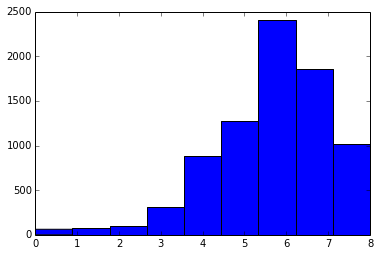

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(t_labels, bins = 9)

In [79]:
stars = np.array(business_ratings.values())
(stars == 3).sum()

8335